# 4. Modeling Tweet Engagement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pickle

%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
mcauliffe_engagement = pd.read_pickle('pickle_files/mcauliffe_engagement_modeling.pkl')
youngkin_engagement = pd.read_pickle('pickle_files/youngkin_engagement_modeling.pkl')
murphyNJ_engagement = pd.read_pickle('pickle_files/murphyNJ_engagement_modeling.pkl')
ciattarelliNJ_engagement = pd.read_pickle('pickle_files/ciattarelliNJ_engagement_modeling.pkl')

In [4]:
mcauliffe_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3005 entries, 0 to 3004
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               3005 non-null   object        
 1   positive_virginia      3005 non-null   float64       
 2   negative_to_opponent   3005 non-null   float64       
 3   GOTV                   3005 non-null   float64       
 4   health_care            3005 non-null   float64       
 5   education_investments  3005 non-null   float64       
 6   reproductive_rights    3005 non-null   float64       
 7   economy                3005 non-null   float64       
 8   clean_energy           3005 non-null   float64       
 9   datetime               3005 non-null   datetime64[ns]
 10  user_handle            3005 non-null   object        
 11  user_followers         3005 non-null   int64         
 12  num_favorites          3005 non-null   int64         
 13  num

In [5]:
youngkin_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 1703
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              1704 non-null   object        
 1   campaign_event        1704 non-null   float64       
 2   thank_supporters      1704 non-null   float64       
 3   negative_to_opponent  1704 non-null   float64       
 4   positive_virginia     1704 non-null   float64       
 5   GOTV                  1704 non-null   float64       
 6   economy               1704 non-null   float64       
 7   datetime              1704 non-null   datetime64[ns]
 8   user_handle           1704 non-null   object        
 9   user_followers        1704 non-null   int64         
 10  num_favorites         1704 non-null   int64         
 11  num_retweets          1704 non-null   int64         
 12  mentions_biden        1704 non-null   int64         
 13  mentions_trump    

In [6]:
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,8))
    
    rgr = LinearRegression()
    rgr.fit(X,y) # fitting linear regression
    pred = rgr.predict(X) # predicting y based on model fit
    res = y - pred
    
    plt.subplot(1,3,1)
    plt.hist(res, color = 'darkseagreen')
    plt.title('Residual distribution', fontsize = 15)
    plt.xticks(fontsize=12);
    
    plt.subplot(1, 3, 2)
    plt.scatter(pred, res)
    plt.title("Residual plot", fontsize = 15)
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", fontsize = 15)

In [7]:
def heat_map_correlation(df):
    df.drop(columns = ['tweet_id','datetime','user_handle'], inplace = True)
    
    fig = plt.figure(figsize = (15,10))
    upper = np.triu(df.corr())
    sns.heatmap(df.corr(), cmap = 'seismic_r',annot=True, vmin=-1, vmax=1, mask=upper);

def basic_regression(df, candidate):
    
    y = df['engagement']
    X_topics = df.drop(columns = ['engagement','num_favorites','num_retweets',
                            'mentions_trump','mentions_biden','mentions_opponent'])
    
    model = LinearRegression()

    model.fit(X_topics, y)
    score = model.score(X_topics, y)

    print('R\u00b2 for baseline engagement model for {} = '.format(candidate), score)
    
    print('-------------------------------')
    
    diagnostic_plot(X_topics, y)

### Terry McAuliffe

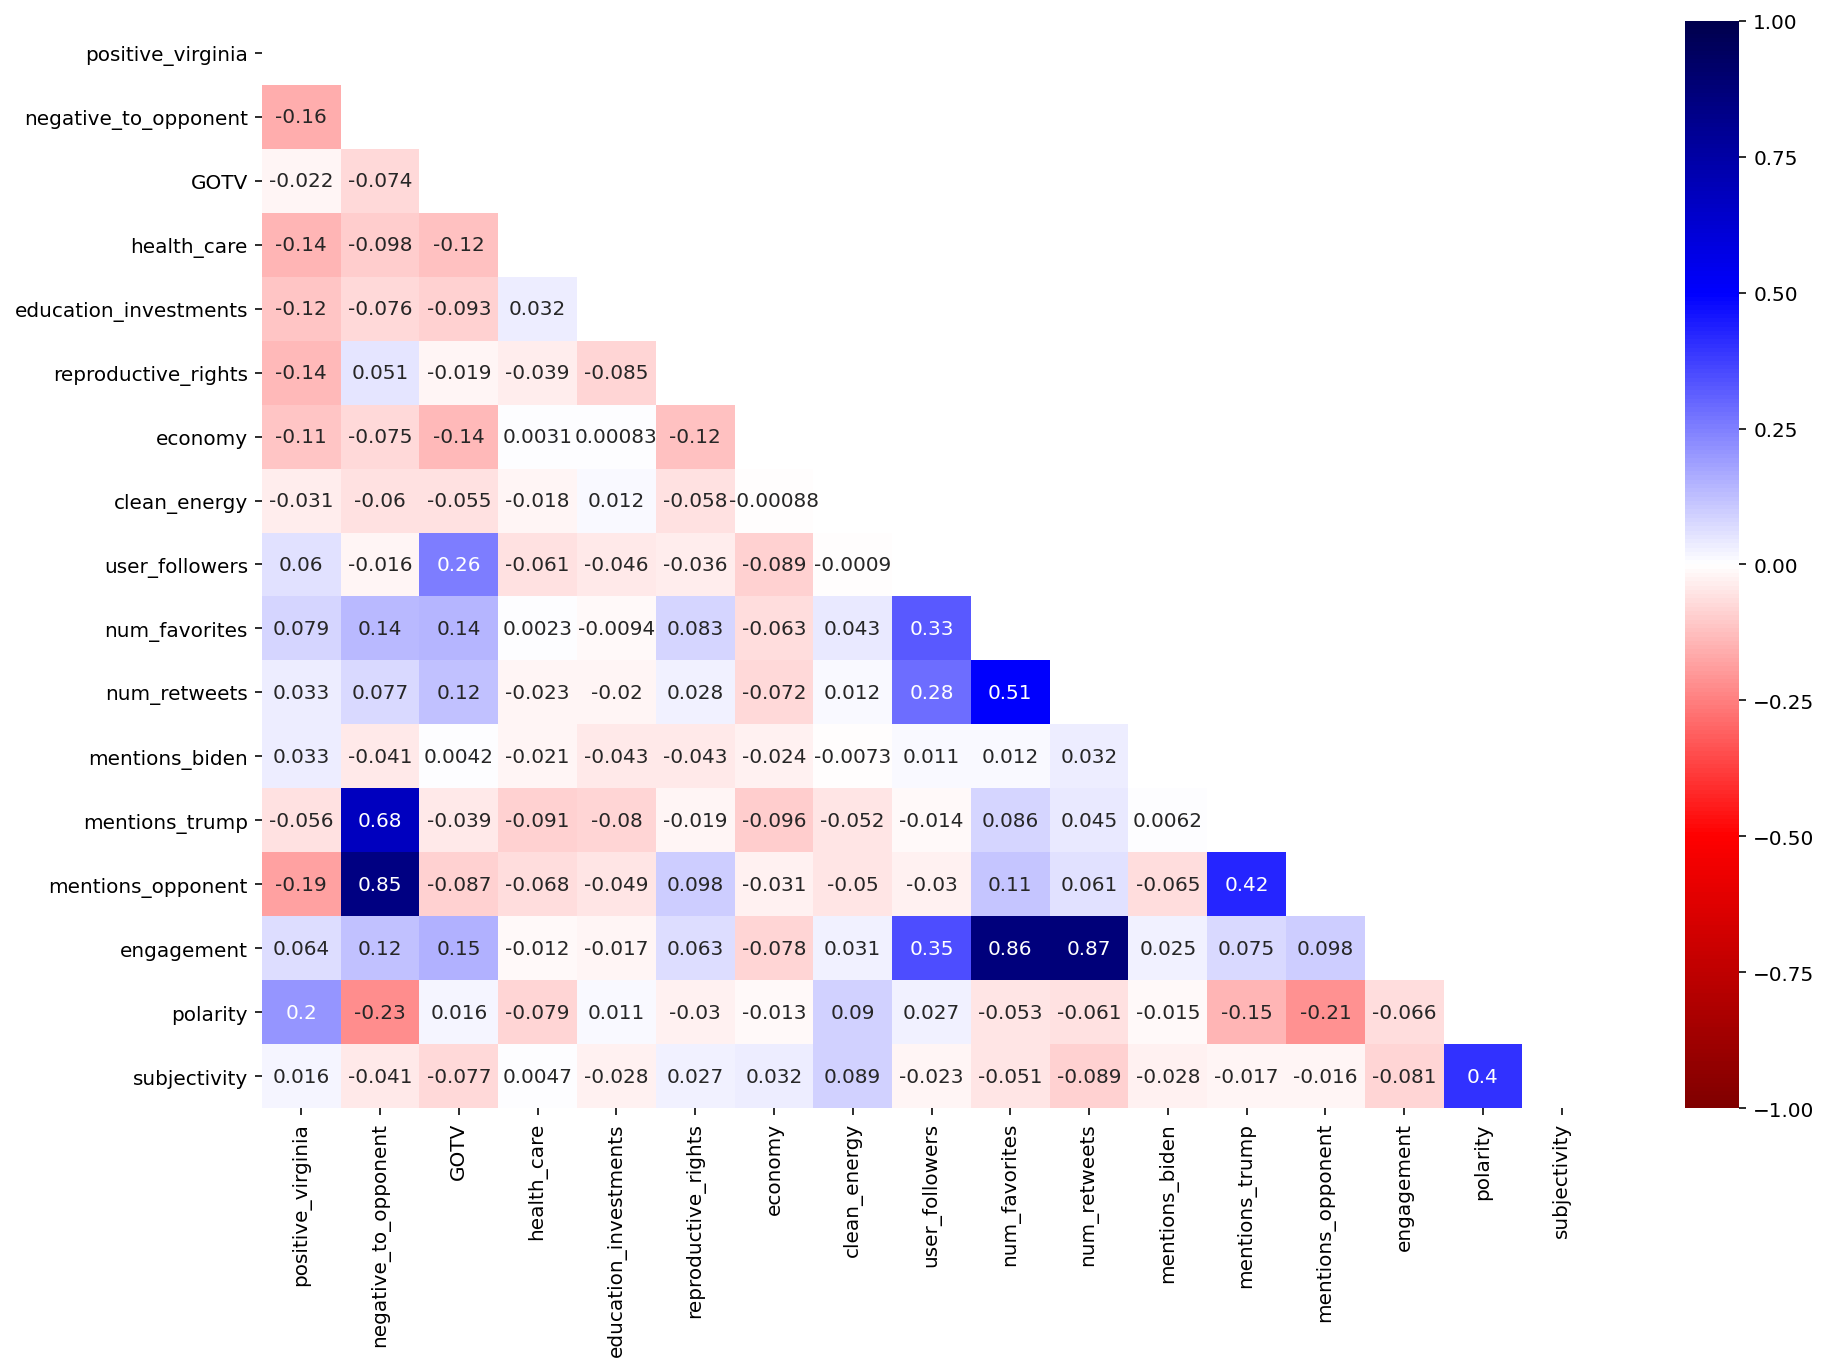

In [8]:
heat_map_correlation(mcauliffe_engagement)

R² for baseline engagement model for Terry McAuliffe =  0.16739048222413677
-------------------------------


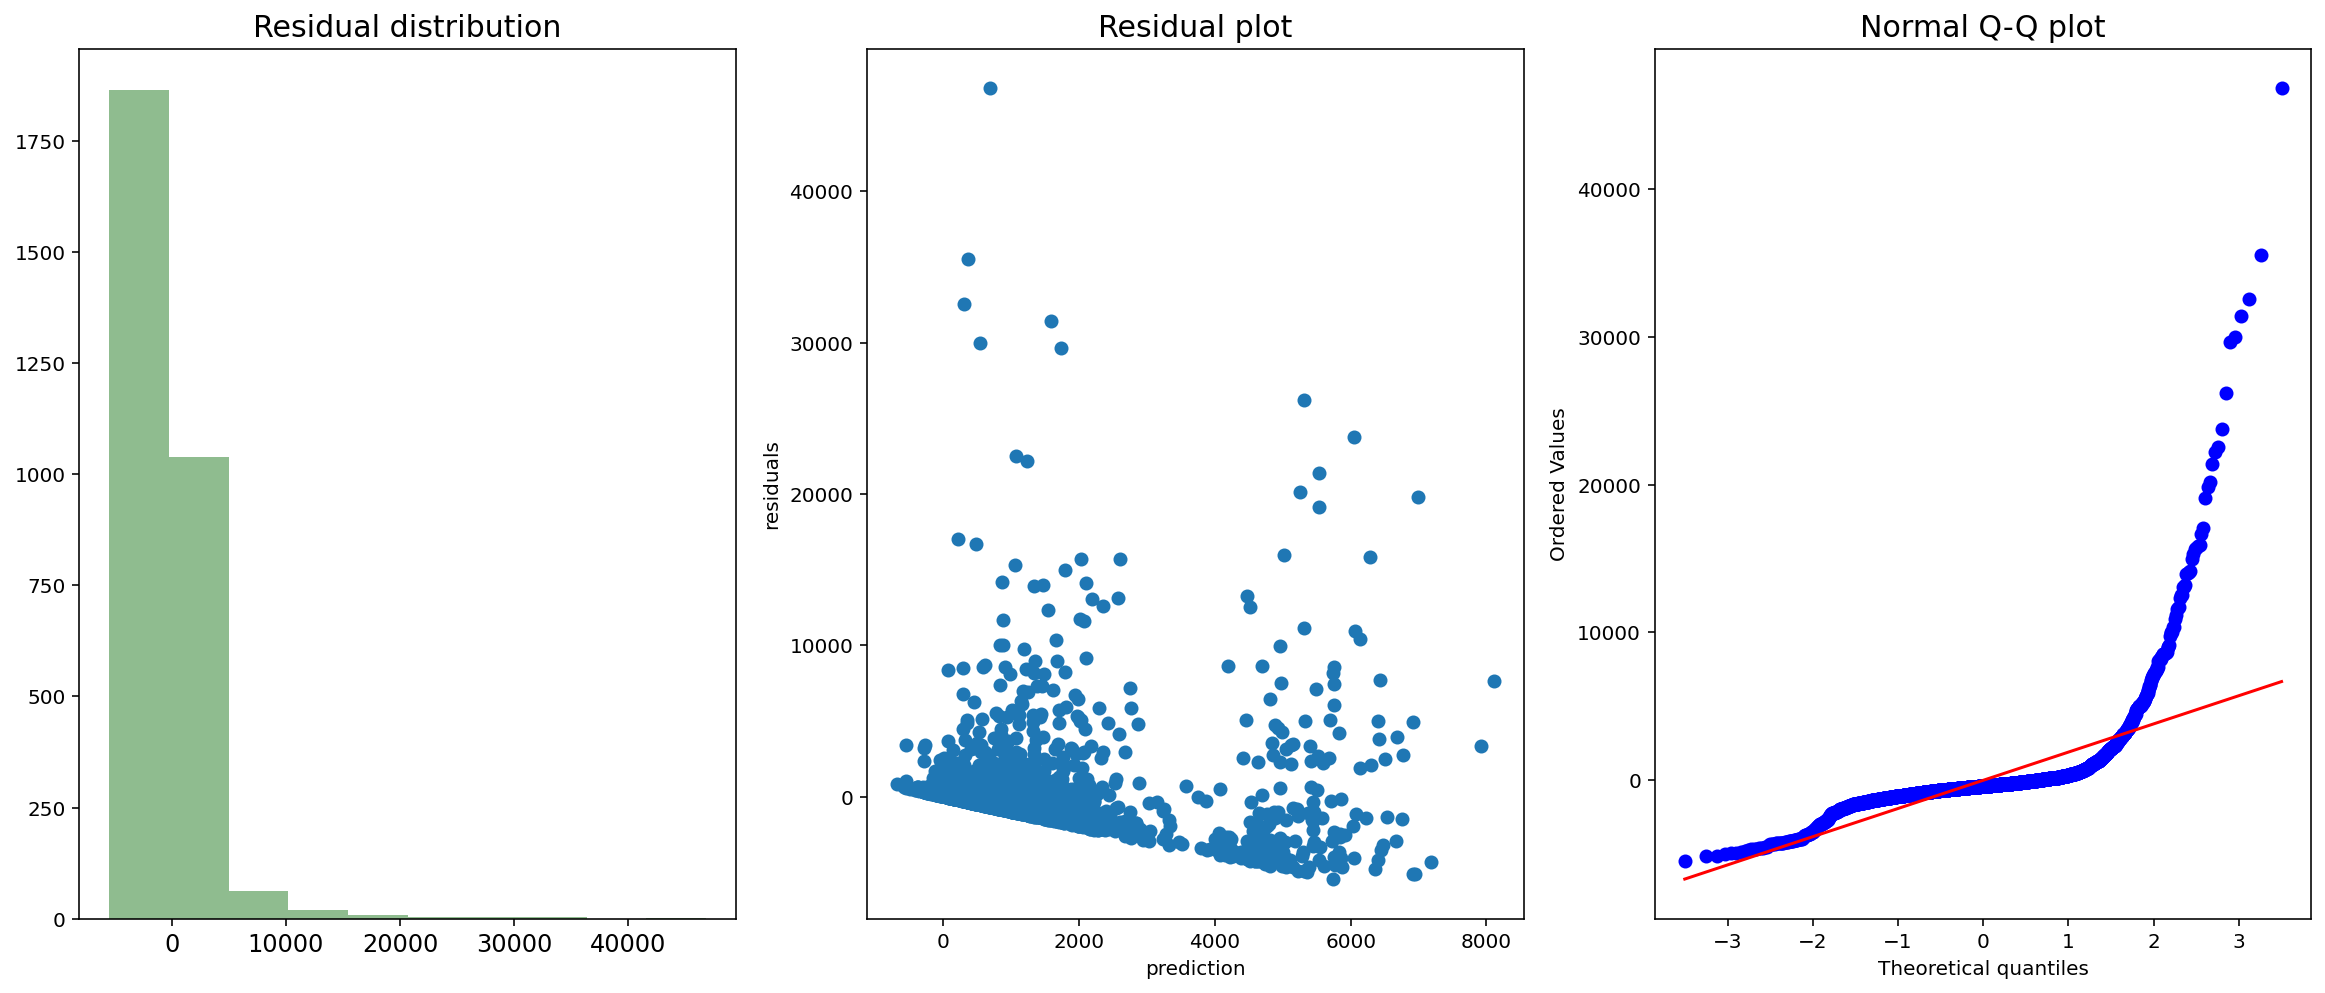

In [9]:
basic_regression(mcauliffe_engagement, 'Terry McAuliffe')

### Glenn Youngkin

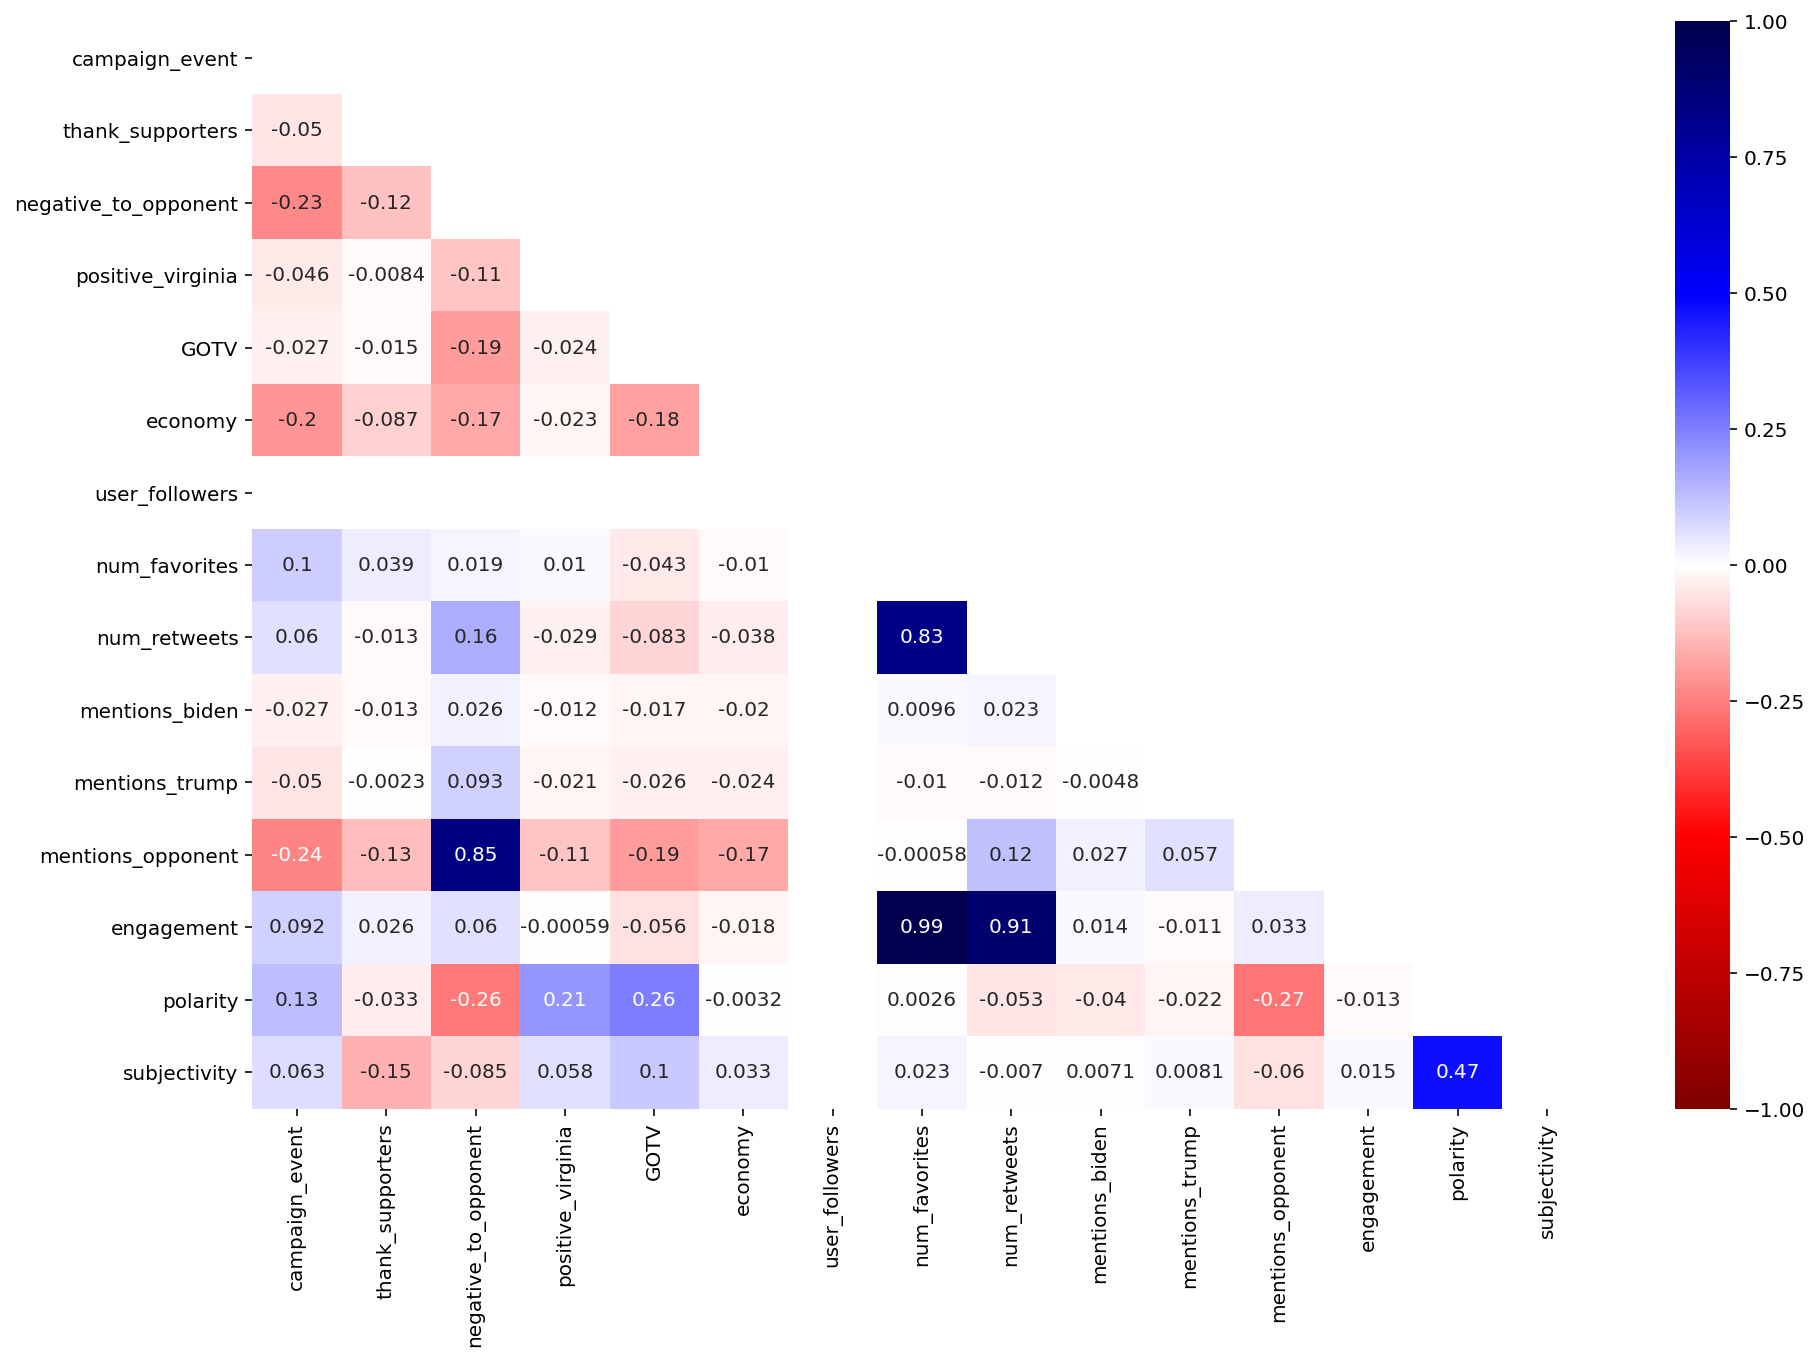

In [10]:
heat_map_correlation(youngkin_engagement)

R² for baseline engagement model for Glenn Youngkin =  0.019745591739707247
-------------------------------


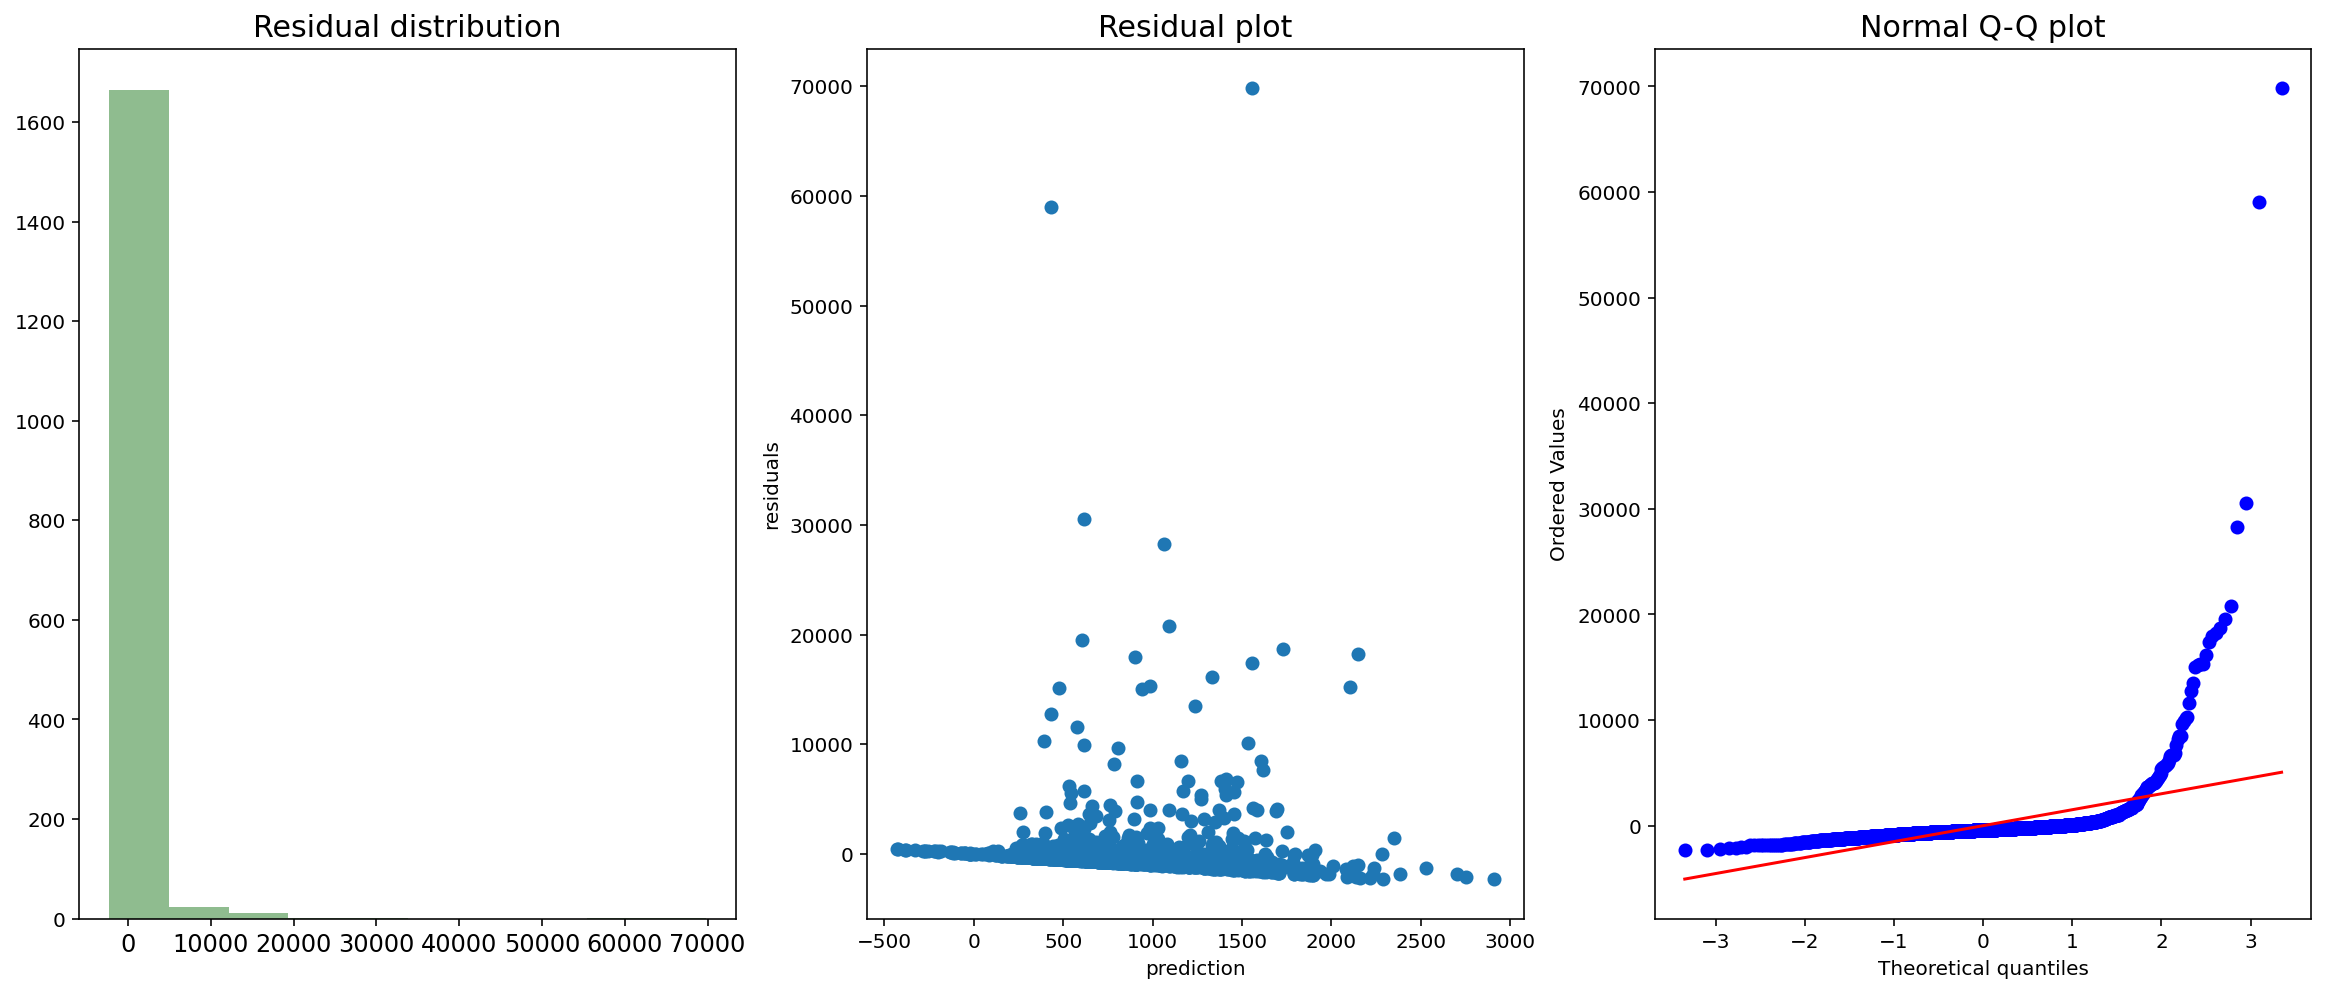

In [11]:
basic_regression(youngkin_engagement, 'Glenn Youngkin')

### Phil Murphy

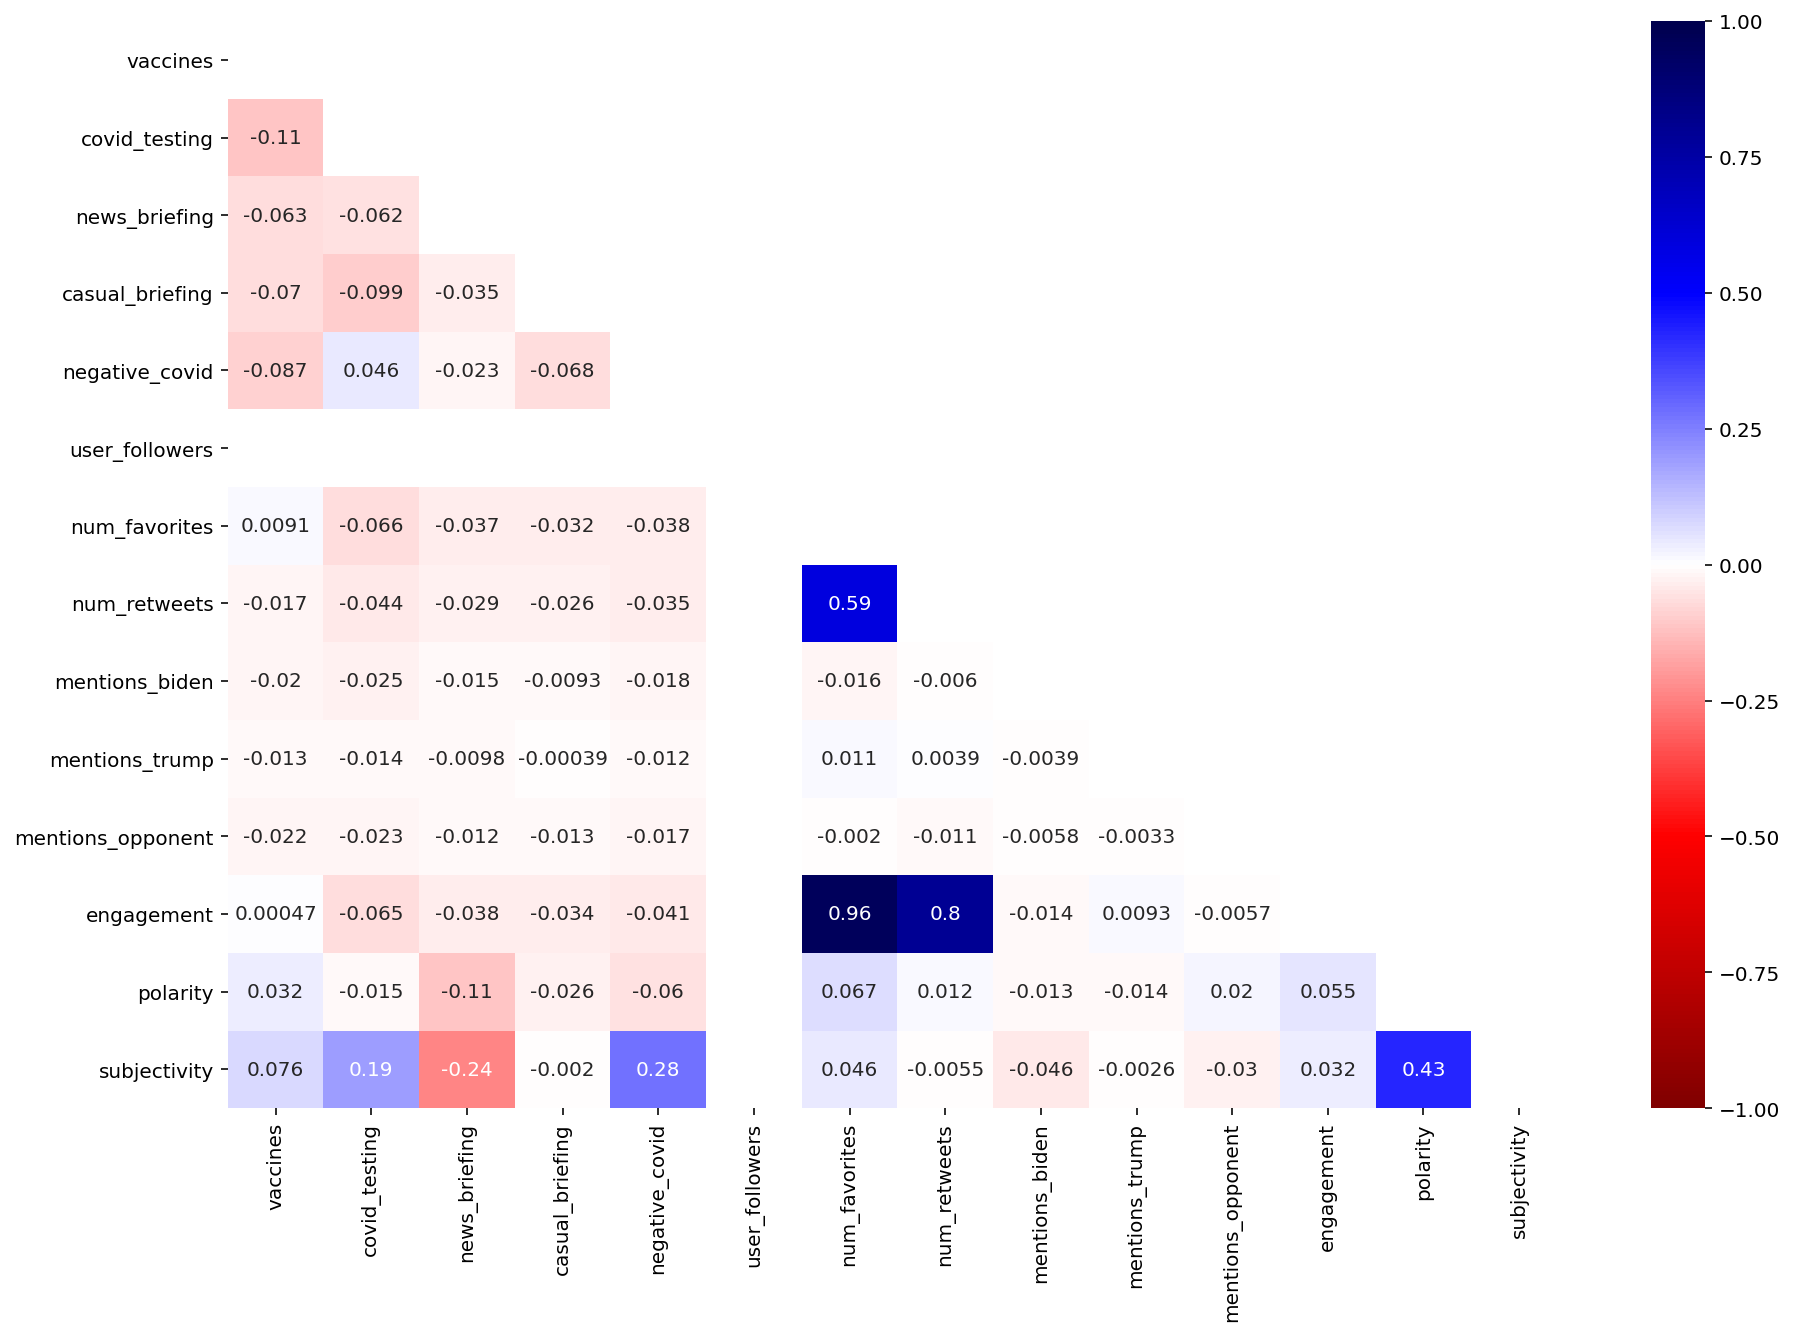

In [12]:
heat_map_correlation(murphyNJ_engagement)

R² for baseline engagement model for Phil Murphy =  0.013105487241422131
-------------------------------


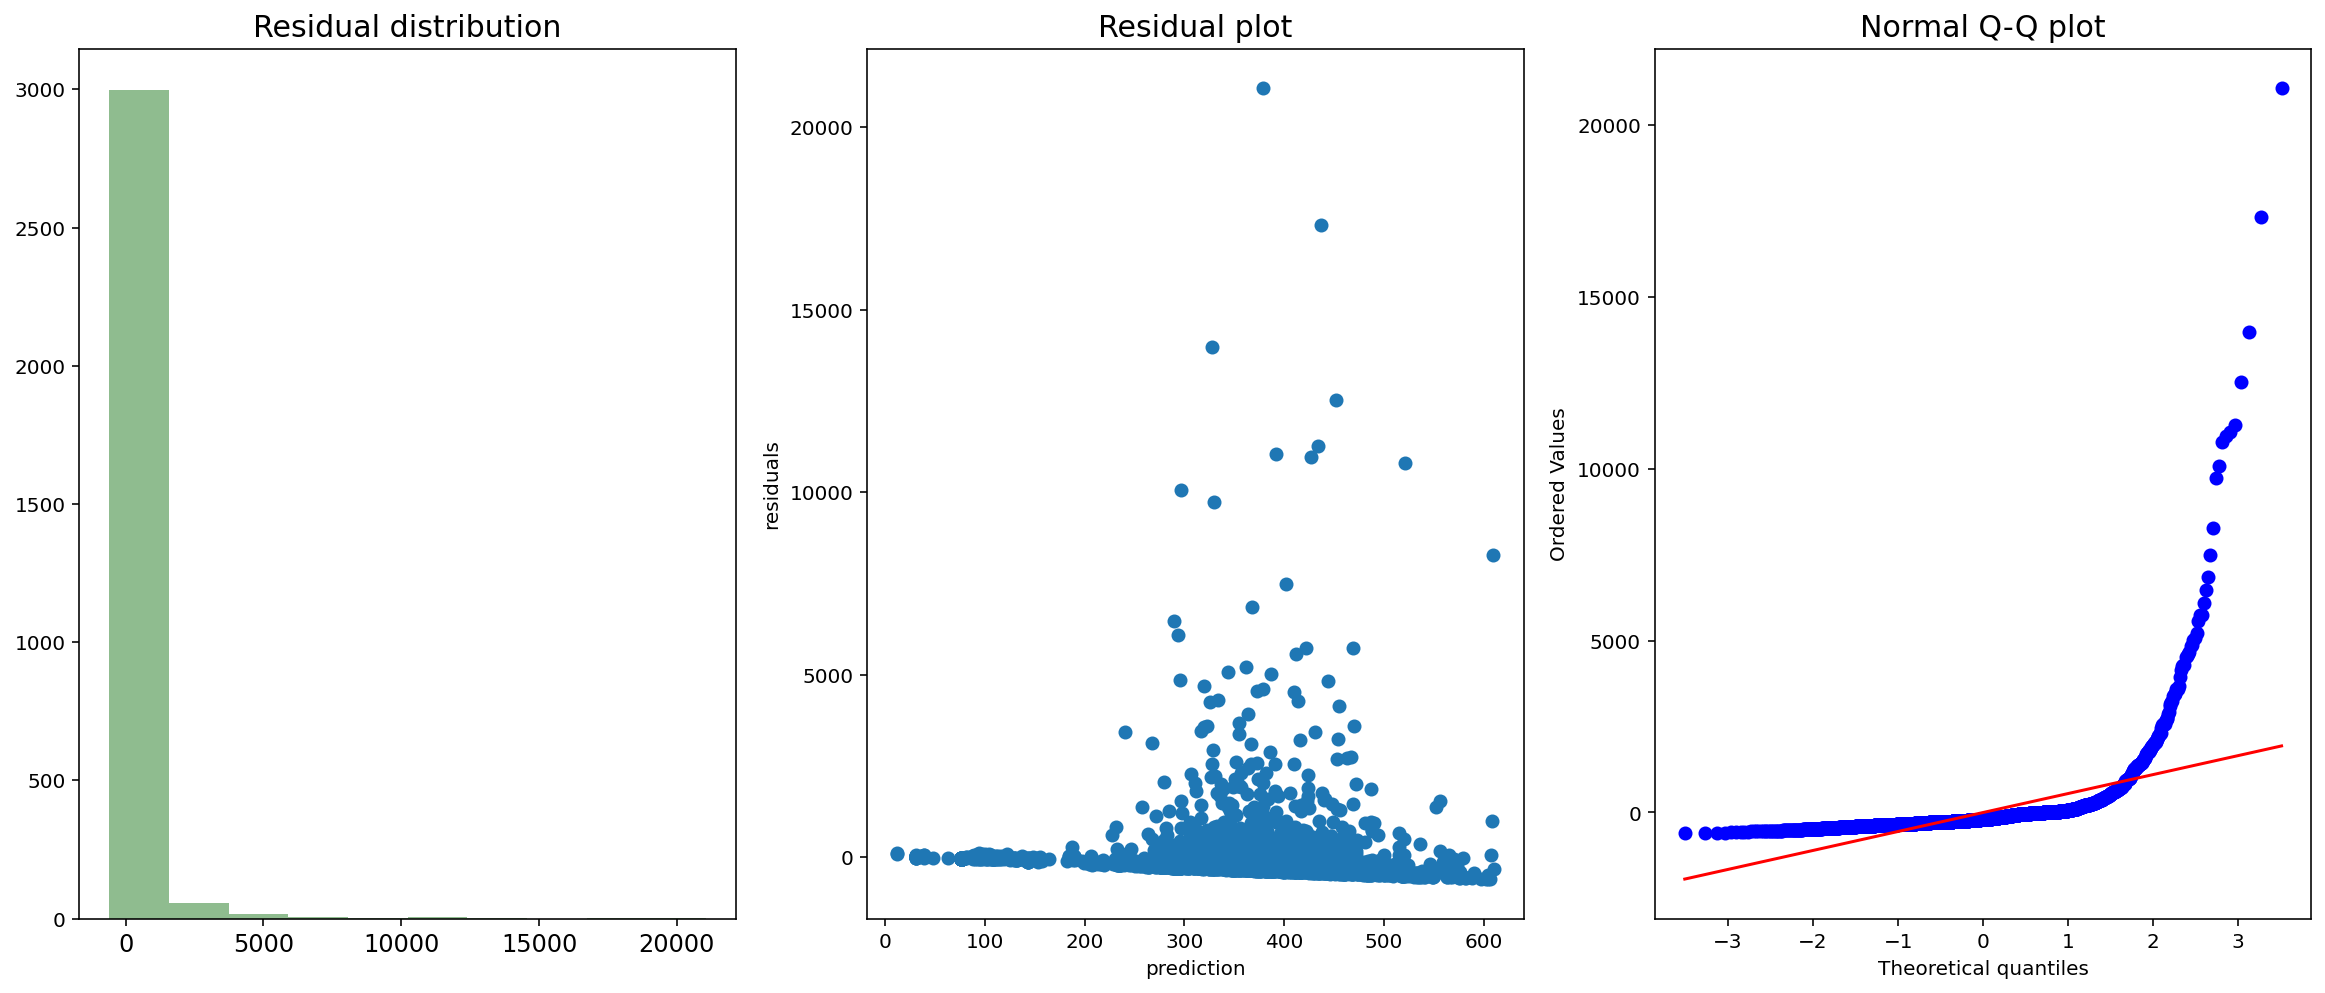

In [13]:
basic_regression(murphyNJ_engagement, 'Phil Murphy')

### Jack Ciattarelli

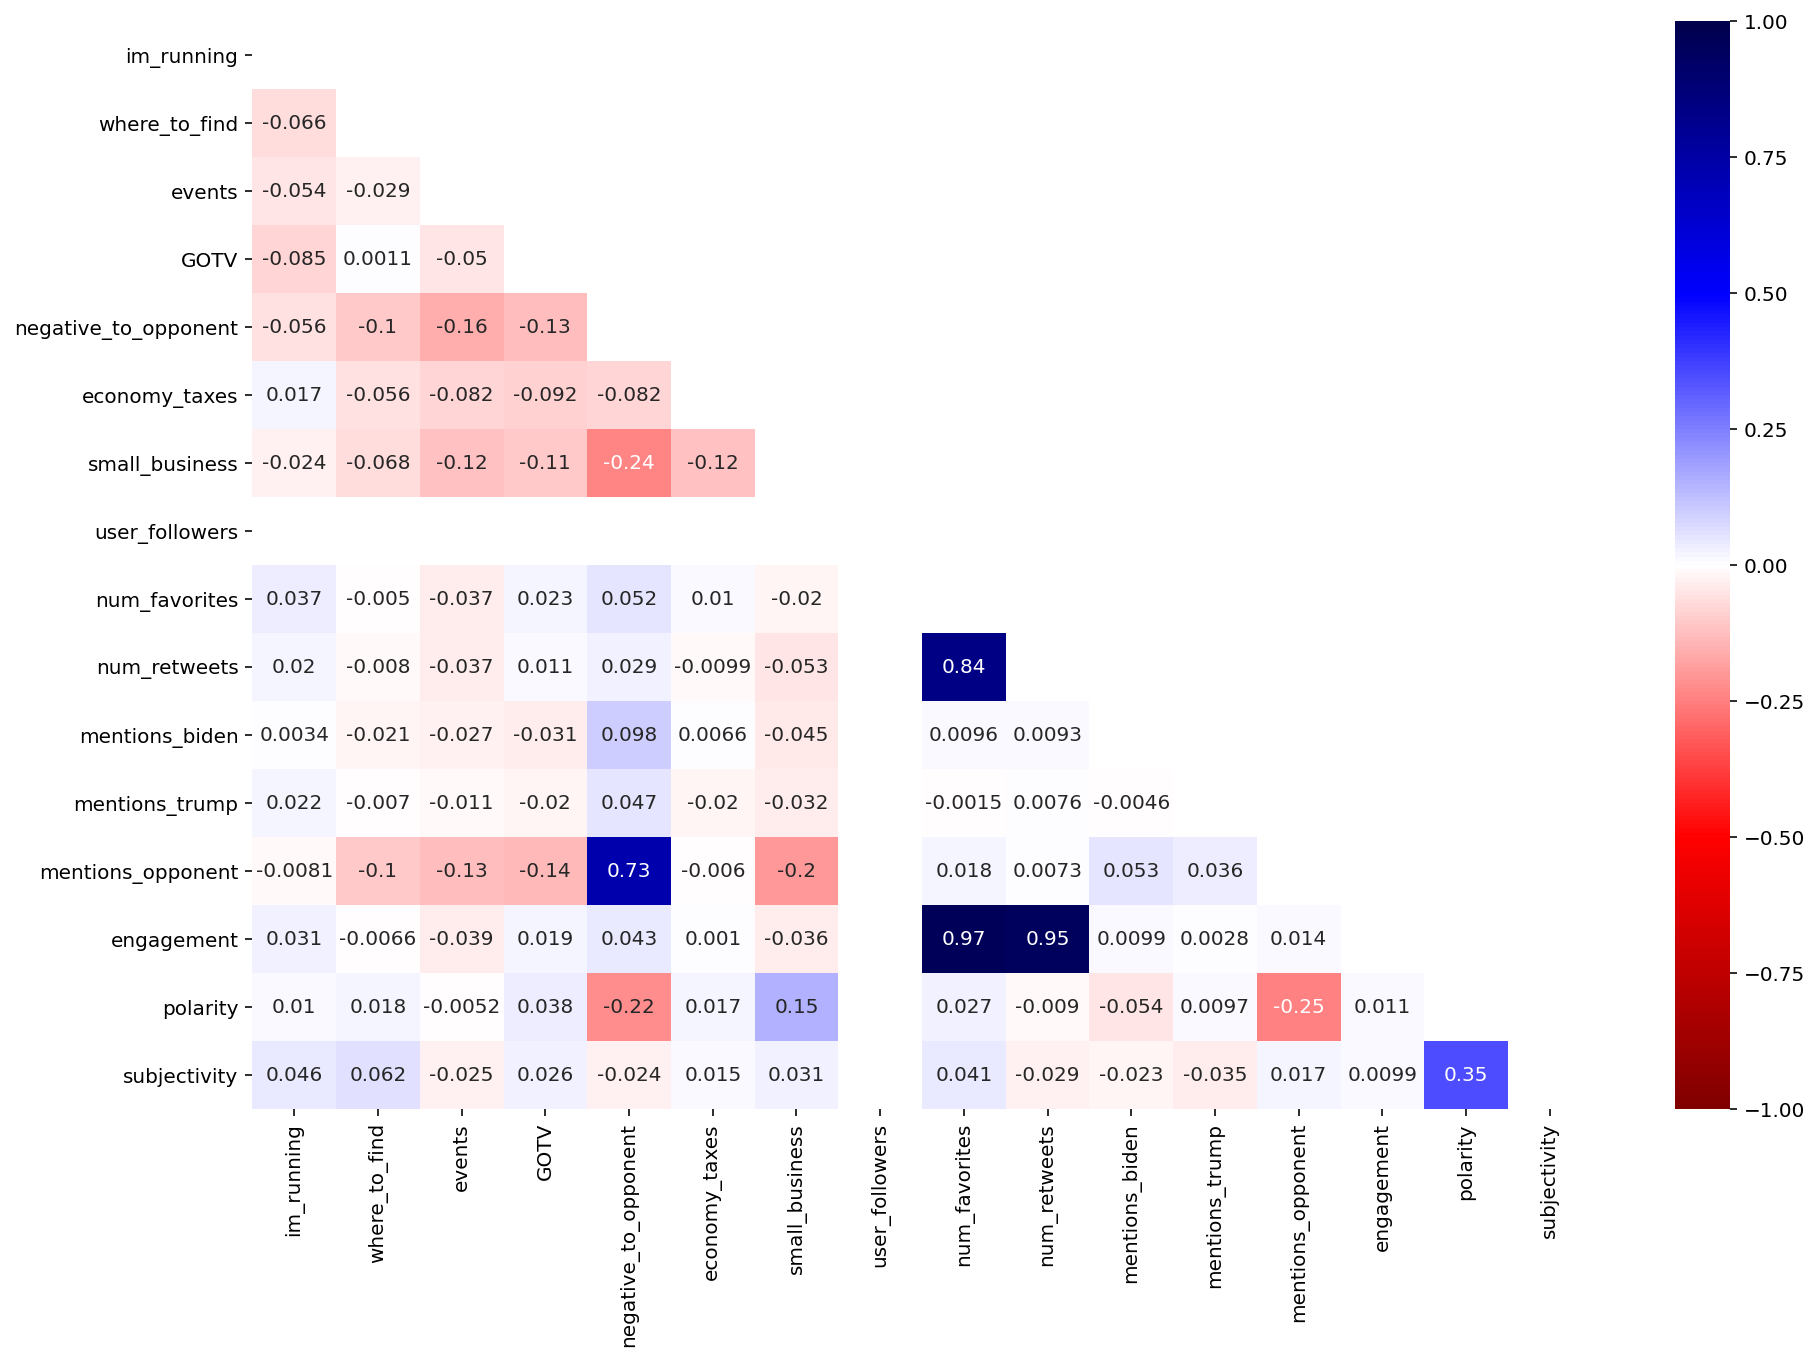

In [14]:
heat_map_correlation(ciattarelliNJ_engagement)

R² for baseline engagement model for Jack Ciattarelli =  0.00584507465636197
-------------------------------


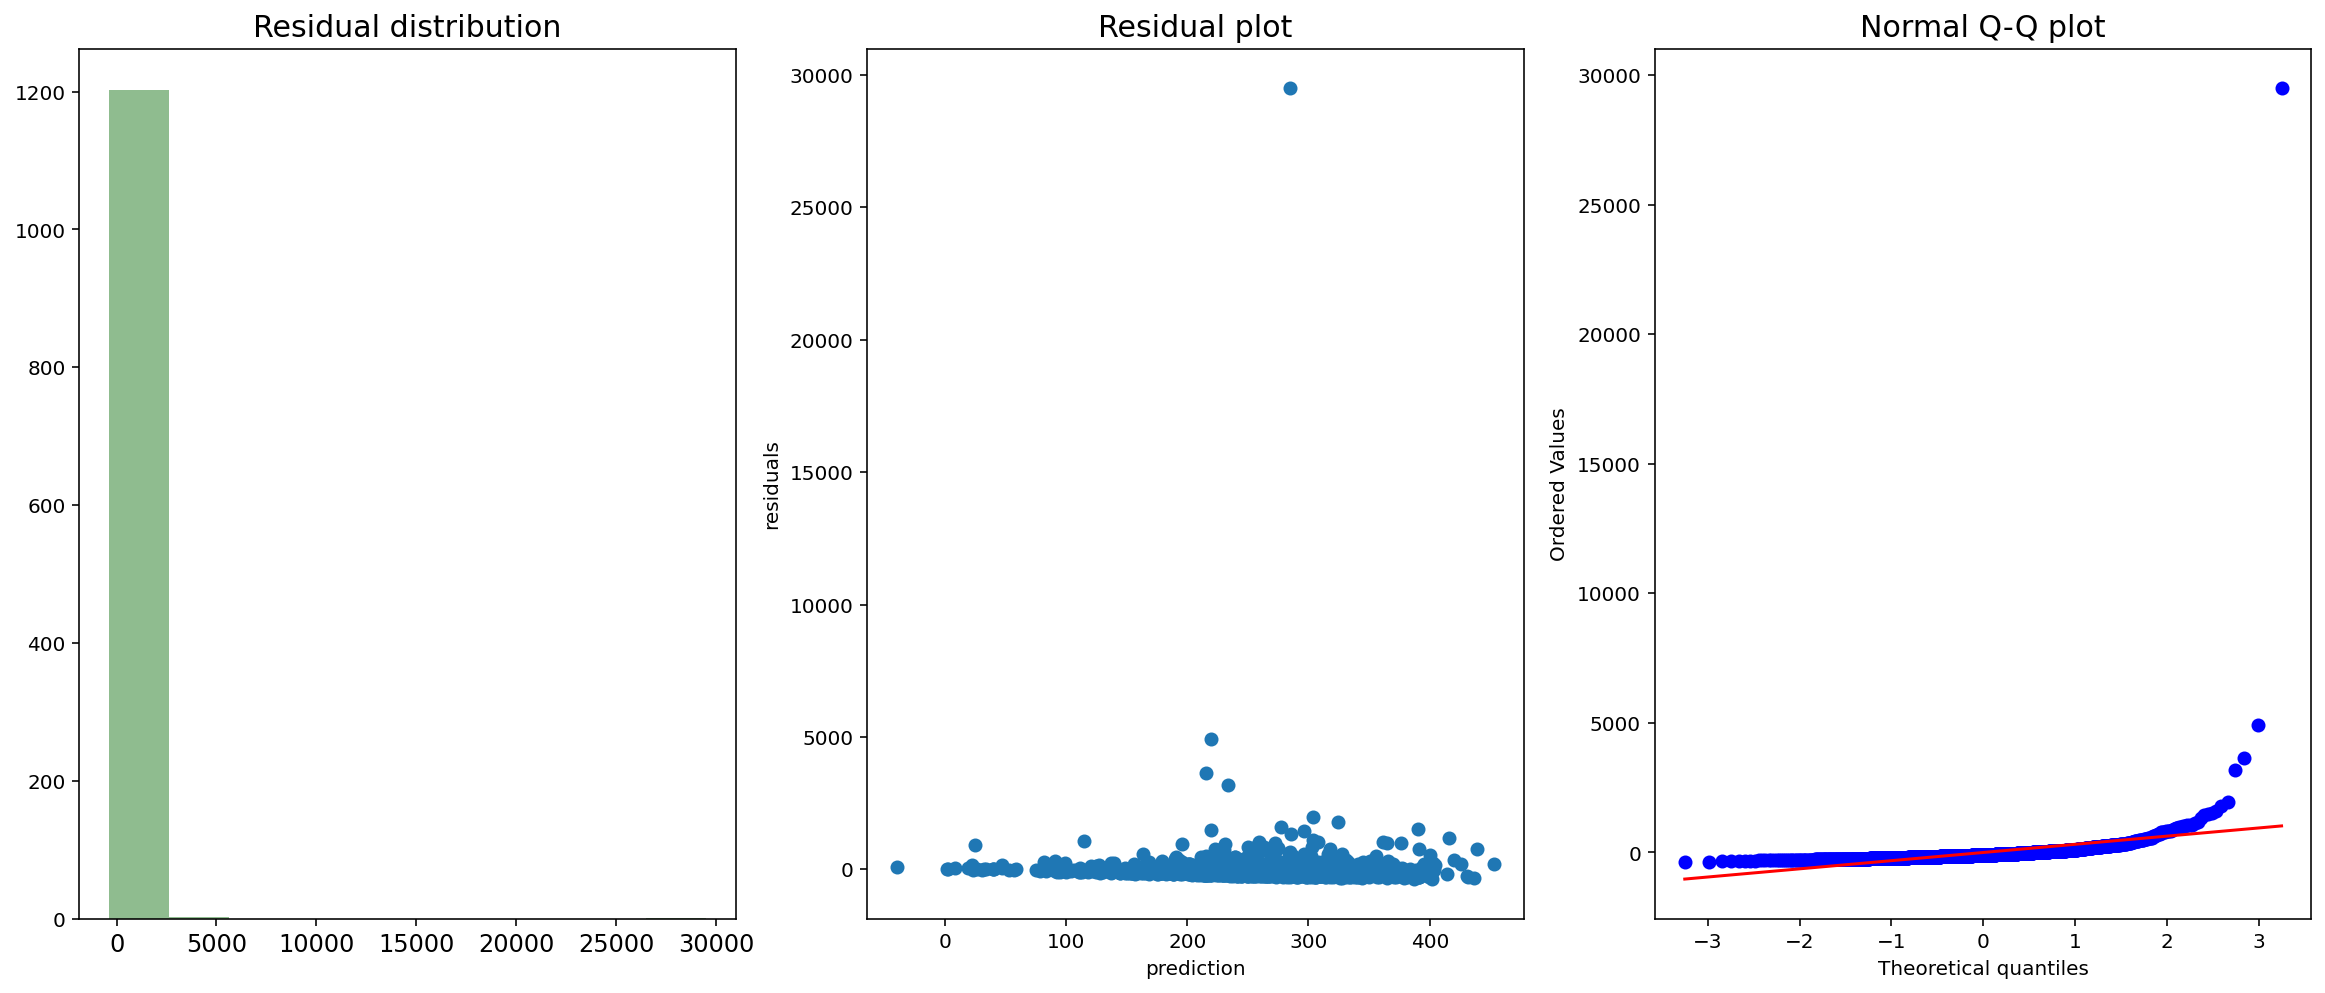

In [15]:
basic_regression(ciattarelliNJ_engagement, 'Jack Ciattarelli')

In [16]:
def cross_validate(df, candidate):
    y = df['engagement']
    X_topics = df.drop(columns = ['engagement','num_favorites','num_retweets',
                            'mentions_trump','mentions_biden','mentions_opponent'])
    
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_topics, 
                                                          y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    
    model = LinearRegression()

    kfold = KFold(n_splits=5, shuffle=True, random_state=5)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)

    print(scores)
    print('Mean R\u00b2 for {} Engagement = '.format(candidate), np.mean(scores))
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    fig = plt.figure(figsize = (5,5))
    plt.scatter(y_train, y_train_pred, alpha=0.2);

[0.24565227 0.07230154 0.15812268 0.10846809 0.16502006]
Mean R² for Terry McAuliffe Engagement =  0.1499129275078258


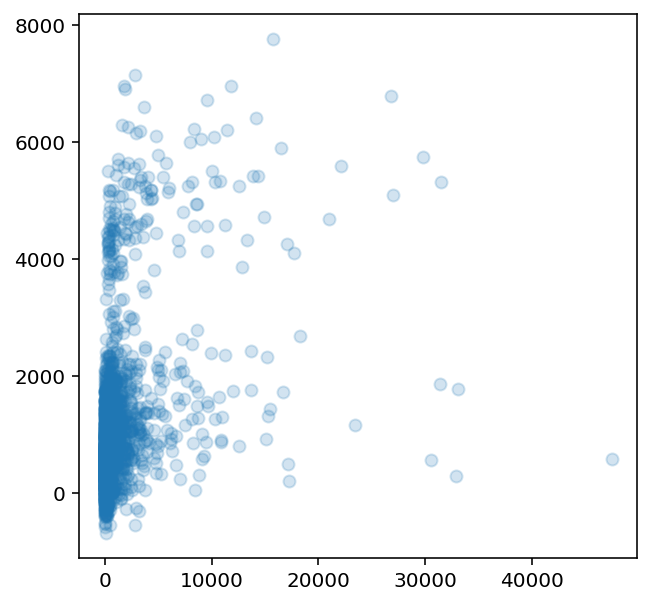

In [17]:
cross_validate(mcauliffe_engagement,'Terry McAuliffe')

[ 0.03228355 -0.02850221 -0.06254766  0.00222431  0.00320569]
Mean R² for Glenn Youngkin Engagement =  -0.01066726383543275


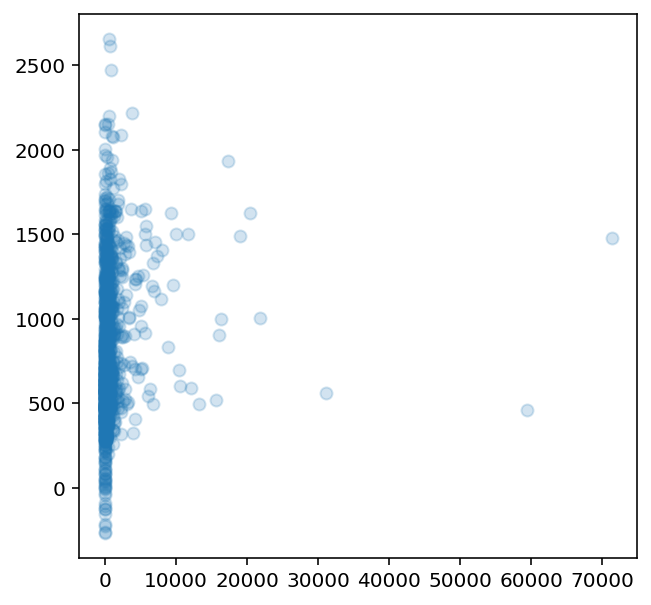

In [18]:
cross_validate(youngkin_engagement, 'Glenn Youngkin')

[ 0.00317528  0.00719986  0.01317284  0.009118   -0.00406157]
Mean R² for Phil Murphy Engagement =  0.005720883182244174


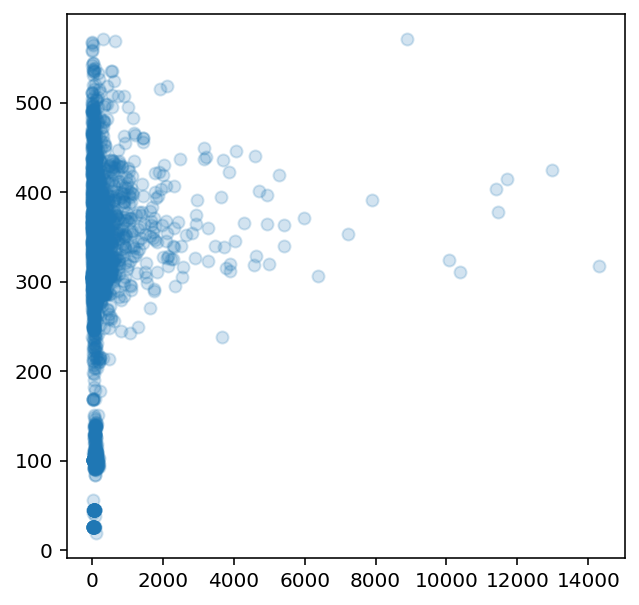

In [19]:
cross_validate(murphyNJ_engagement, 'Phil Murphy')

[-0.04424501 -0.15179429 -0.03372    -0.00637185 -0.02142816]
Mean R² for Jack Ciattarelli Engagement =  -0.05151186110295898


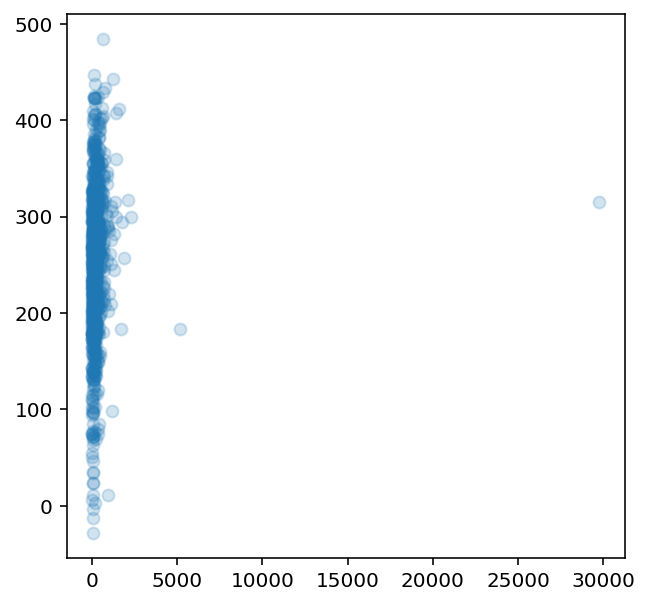

In [20]:
cross_validate(ciattarelliNJ_engagement, 'Jack Ciattarelli')

In [21]:
def OLS_model(df, candidate):
    y = df['engagement']
    X_topics = df.drop(columns = ['engagement','num_favorites','num_retweets',
                            'mentions_trump','mentions_biden','mentions_opponent'])
    
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_topics, 
                                                          y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    model = sm.OLS(y_train, sm.add_constant(X_train))
    fit = model.fit()
    return fit.summary()


In [22]:
OLS_model(mcauliffe_engagement,'Terry McAuliffe')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             engagement   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     39.98
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           6.80e-80
Time:                        21:50:34   Log-Likelihood:                -22430.
No. Observations:                2404   AIC:                         4.488e+04
Df Residuals:                    2392   BIC:                         4.495e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -4.82e+08   3.05e+07    -15.807      0.000   -5.42e+08   -4.22e+08
positive_virginia      1.543e+04   2845.931      5.422      0.000    9849.665     2.1e+04
negative_to_opponent   9804.3033   1344.306      7.293      0.000    7168.177    1.24e+04
GOTV                   7843.9685   1491.905      5.258      0.000    4918.409    1.08e+04
health_care            5772.4445   1658.259      3.481      0.001    2520.671    9024.218
education_investments  2043.9305   1398.395      1.462      0.144    -698.261    4786.122
reproductive_rights    4925.1872   1448.435      3.400      0.001    2084.870    7765.505
economy                -205.9889   1449.178     -0.142      0.887   -3047.763    2635.785
clean_energy           4348.8698   1425.683      3.050      0.002    1553.167    7144.572
user_followers         3831.4258    242.382     15.807      0.000    3356.125    4306.726
polarity               -383.4567    207.983     -1.844      0.065    -791.302      24.389
subjectivity           -579.1496    215.673     -2.685      0.007   -1002.075    -156.224
==============================================================================
Omnibus:                     3137.045   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           633233.337
Skew:                           7.148   Prob(JB):                         0.00
Kurtosis:                      81.214   Cond. No.                     6.88e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
OLS_model(youngkin_engagement, 'Glenn Youngkin')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             engagement   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.886
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00344
Time:                        21:50:34   Log-Likelihood:                -12914.
No. Observations:                1363   AIC:                         2.585e+04
Df Residuals:                    1354   BIC:                         2.589e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
campaign_event        9945.1022   2692.065      3.694      0.000    4664.032    1.52e+04
thank_supporters      3136.3872   1679.499      1.867      0.062    -158.316    6431.090
negative_to_opponent  5873.5348   2077.758      2.827      0.005    1797.561    9949.508
positive_virginia     1245.1892   1548.660      0.804      0.422   -1792.844    4283.223
GOTV                 -1229.1547   1729.022     -0.711      0.477   -4621.008    2162.698
economy               1212.1922   2115.947      0.573      0.567   -2938.699    5363.083
user_followers           0.0018      0.002      1.200      0.230      -0.001       0.005
polarity              -166.5098    350.589     -0.475      0.635    -854.267     521.247
subjectivity           176.2103    365.446      0.482      0.630    -540.692     893.112
==============================================================================
Omnibus:                     2646.110   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4387309.596
Skew:                          14.588   Prob(JB):                         0.00
Kurtosis:                     279.408   Cond. No.                     5.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
OLS_model(murphyNJ_engagement, 'Phil Murphy')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             engagement   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.938
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           1.48e-05
Time:                        21:50:34   Log-Likelihood:                -20239.
No. Observations:                2468   AIC:                         4.049e+04
Df Residuals:                    2460   BIC:                         4.054e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
vaccines         -373.7826    321.194     -1.164      0.245   -1003.621     256.055
covid_testing   -1221.5729    310.601     -3.933      0.000   -1830.639    -612.507
news_briefing    -833.8274    443.258     -1.881      0.060   -1703.024      35.370
casual_briefing  -919.3821    375.425     -2.449      0.014   -1655.565    -183.200
negative_covid   -968.6464    444.193     -2.181      0.029   -1839.677     -97.616
user_followers      0.0008      0.000      7.516      0.000       0.001       0.001
polarity          157.3578    100.029      1.573      0.116     -38.792     353.507
subjectivity      104.4419     92.645      1.127      0.260     -77.228     286.112
==============================================================================
Omnibus:                     3551.852   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           984786.223
Skew:                           8.534   Prob(JB):                         0.00
Kurtosis:                      99.360   Cond. No.                     1.05e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
OLS_model(ciattarelliNJ_engagement, 'Jack Ciattarelli')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             engagement   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6204
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.780
Time:                        21:50:34   Log-Likelihood:                -8022.1
No. Observations:                 964   AIC:                         1.606e+04
Df Residuals:                     954   BIC:                         1.611e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
im_running             813.5567    932.323      0.873      0.383   -1016.084    2643.198
where_to_find         -104.9900    561.246     -0.187      0.852   -1206.410     996.430
events                -591.6525    720.625     -0.821      0.412   -2005.846     822.541
GOTV                   398.1009    677.591      0.588      0.557    -931.640    1727.842
negative_to_opponent   886.8883    858.327      1.033      0.302    -797.540    2571.316
economy_taxes          -14.4430    734.641     -0.020      0.984   -1456.142    1427.256
small_business        -600.3656    733.988     -0.818      0.414   -2040.782     840.051
user_followers           0.0049      0.003      1.922      0.055      -0.000       0.010
polarity               118.0653    138.333      0.853      0.394    -153.407     389.537
subjectivity            68.6363    147.353      0.466      0.641    -220.536     357.809
==============================================================================
Omnibus:                     2488.680   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25517897.967
Skew:                          27.105   Prob(JB):                         0.00
Kurtosis:                     798.212   Cond. No.                     1.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""